In [1]:
import latentvelo as ltv
import scvelo as scv
import numpy as np
import scanpy as sc
np.random.seed(1)

Global seed set to 0


In [2]:
adata = scv.datasets.pbmc68k()
scv.pp.remove_duplicate_cells(adata)
adata.obsm["X_tsne"][:, 0] *= -1

In [3]:
adata.obs['celltype_names'] = adata.obs.celltype.values

In [4]:
scv.pp.filter_genes(adata, min_shared_counts=30)

Filtered out 33500 genes that are detected 30 counts (shared).


In [6]:
spliced_library_sizes = adata.layers['spliced'].sum(1)
unspliced_library_sizes = adata.layers['unspliced'].sum(1)

In [7]:
adata = adata[(spliced_library_sizes > 0) & (unspliced_library_sizes > 0)]

In [8]:
sc.pp.filter_cells(adata, min_genes=30)

In [9]:
adata = adata[np.random.choice(adata.shape[0], size=30000, replace=False)]

In [10]:
adata = ltv.utils.anvi_clean_recipe(adata, spliced_key='spliced', unspliced_key='unspliced',
                           celltype_key='celltype')

Skip filtering by dispersion since number of variables are less than `n_top_genes`.
using all genes
computing neighbors
    finished (0:00:22) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


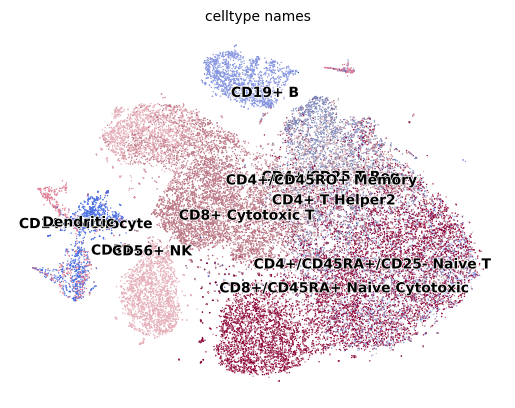

In [11]:
scv.pl.tsne(adata, color=['celltype_names'])

In [12]:
model = ltv.models.VAE(observed=439, latent_dim=50, encoder_hidden=75, zr_dim=2, h_dim=2,
                           celltypes=len(adata.obs.celltype.unique()), correlation_reg=False,
                      splicing_bias=False) # remove bias, since input is mainly noise

In [13]:
epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 1000, learning_rate = 5e-3,
                                      epochs=1, name='PBMC', grad_clip=1000)

Warning, folder already exists. This may overwrite a previous fit.
45 velocity genes used
epoch 0, full loss 451.552, val loss 90.844, recon MSE 0.373, traj MSE 0.075, reg loss 0.000
Loading best model at 0 epochs.


In [14]:
import torch as th
model.load_state_dict(th.load('PBMC/model_state_epoch15.params',map_location=th.device('cuda')))

<All keys matched successfully>

In [15]:
latent_adata, adata = ltv.output_results(model, adata, embedding='tsne', gene_velocity=True)

In [16]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/30000 [00:00<?, ?cells/s]

    finished (0:00:18) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [17]:
latent_adata.obs['celltype'] = adata.obs.celltype_names.values

computing velocity embedding
    finished (0:00:06) --> added
    'spliced_velocity_tsne', embedded velocity vectors (adata.obsm)
saving figure to file figures/PBMC_tsne_celltype.png


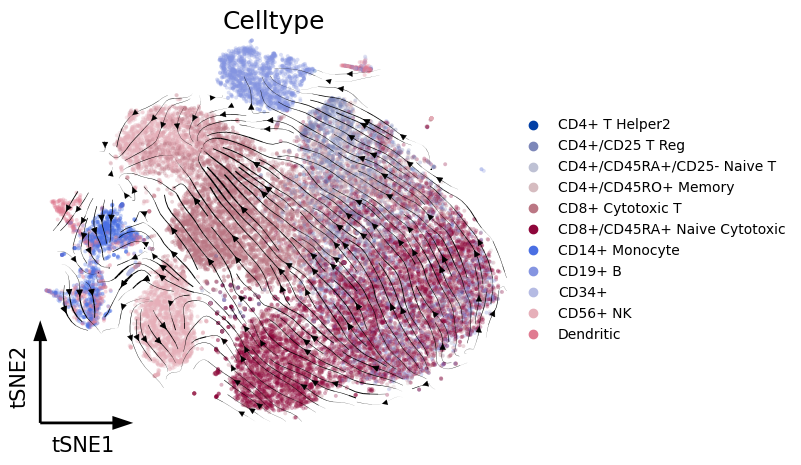

saving figure to file figures/PBMC_tsne_latentime.png


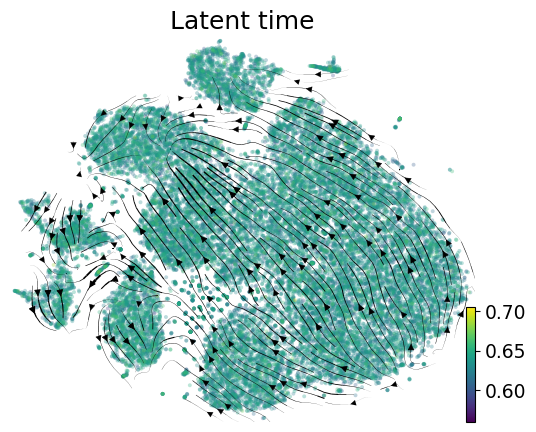

saving figure to file figures/PBMC_tsne_error.png


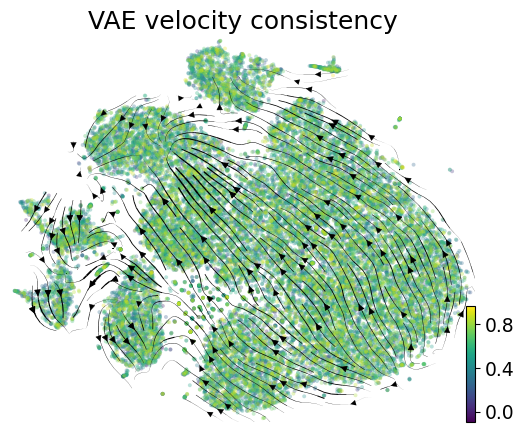

In [18]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', basis='tsne',
                                 color=['celltype'], legend_loc='right',
                                title=['Celltype'],fontsize=18,figsize=(6,5),
                                frameon='artist', save='figures/PBMC_tsne_celltype.png')

scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', basis='tsne',
                                 color=['latent_time'], legend_loc='right',fontsize=18,figsize=(6,5),
                                title=['Latent time'], save='figures/PBMC_tsne_latentime.png')

scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', basis='tsne',
                                 color=['cosine_error'], legend_loc='right',fontsize=18,figsize=(6,5),
                                title=['VAE velocity consistency'], save='figures/PBMC_tsne_error.png')

In [19]:
scv.pp.neighbors(latent_adata, n_neighbors=30, use_rep='X')
scv.tl.umap(latent_adata)

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [20]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')


computing velocity graph (using 1/16 cores)


  0%|          | 0/30000 [00:00<?, ?cells/s]

    finished (0:00:19) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:06) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/PBMC_umap_celltype.png


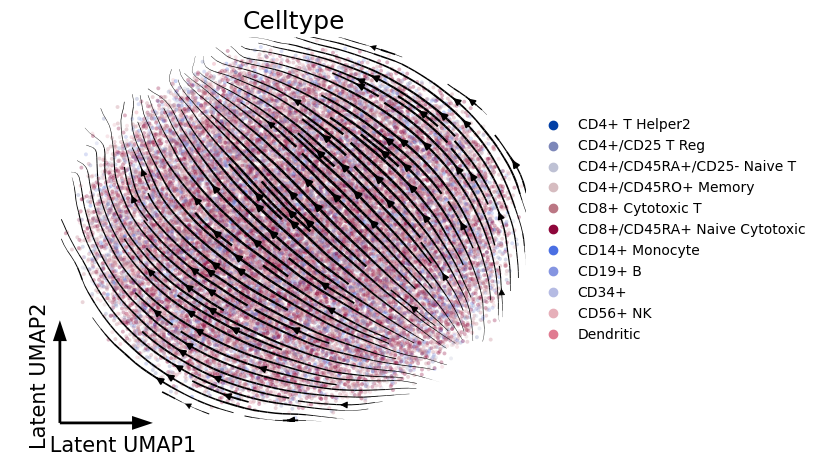

saving figure to file figures/PBMC_umap_latentime.png


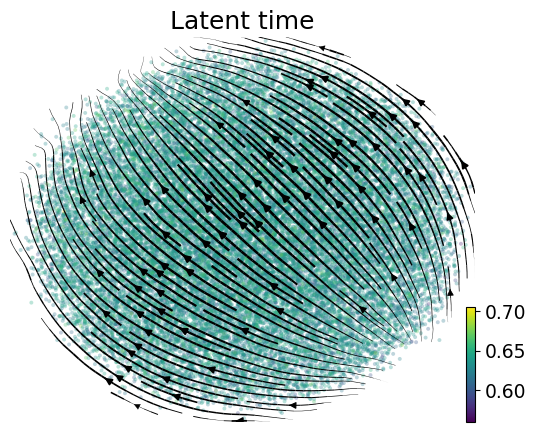

saving figure to file figures/PBMC_umap_error.png


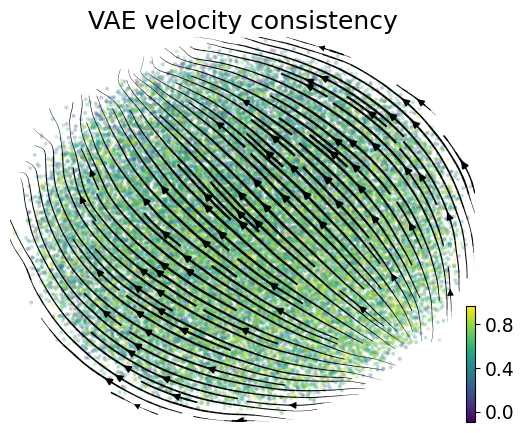

In [21]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', basis='umap',
                                 color=['celltype'], legend_loc='right',
                                title=['Celltype'],figsize=(6,5),fontsize=18,
                                frameon='artist', save='figures/PBMC_umap_celltype.png',
                                xlabel='      Latent UMAP1', ylabel='Latent UMAP2')

scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', basis='umap',
                                 color=['latent_time'], legend_loc='right',figsize=(6,5),fontsize=18,
                                title=['Latent time'], save='figures/PBMC_umap_latentime.png',
                                xlabel='Latent UMAP1', ylabel='Latent UMAP2')

scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', basis='umap',
                                 color=['cosine_error'], legend_loc='right',figsize=(6,5),fontsize=18,
                                title=['VAE velocity consistency'], save='figures/PBMC_umap_error.png',
                                xlabel='Latent UMAP1', ylabel='Latent UMAP2')